# Supervised Learning with toybrains dataset using Lightning
> Dev log (format < Date > | <Author(s)> )  
> - Developed: 30 May 2023 | JiHoon Kim <br>
> - Tested and improved: 17 July 2023 | Roshan Rane <br>
> - Tested: 28 July 2023 | JiHoon Kim <br>
> - Updated: 18 October 2023 | JiHoon Kim

NOTE : 
- shuffle recommended `False` on both val, and test in dataloader
- used as a testbed notebook (outdated)

## load libraries

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# check GPUs available and memory
! gpustat

cuda02                      Wed Oct 18 15:48:47 2023  535.104.12
[0] NVIDIA GeForce RTX 3090 | 69°C,  95 % | 19781 / 24576 MB | sam(19764M) gdm(4M)
[1] NVIDIA GeForce RTX 3090 | 40°C,   0 % |    12 / 24576 MB | gdm(4M)
[2] NVIDIA GeForce RTX 3090 | 31°C,   0 % |    12 / 24576 MB | gdm(4M)
[3] NVIDIA GeForce RTX 3090 | 70°C,  92 % | 19781 / 24576 MB | sam(19764M) gdm(4M)


In [3]:
GPUs = [1]

In [19]:
! CUDA_LAUNCH_BLOCKING=1

In [20]:
torch.set_float32_matmul_precision('medium')

In [4]:
# standard python packages
import os, sys
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import random

In [5]:
import torch
# import monai
import lightning as L
from lightning.pytorch.loggers import CSVLogger
# add custom imports
# (TODO) refactoring needed
sys.path.insert(0, "../")
from utils.dataset import split_dataset
from utils.DLutils import (
    get_dataset_loaders,
    ToyBrainsDataset, LightningModel,
    PyTorchMLP, LogisticRegression, SimpleCNN,
    viz_batch
)

## Generate toybrain datasets 
```bash
$ nohup python3 create_toybrains.py -c configs.lbl1cov1 -n 10000 &> nohup1.out &
$ nohup python3 create_toybrains.py -c configs.lbl1cov1_midsignal -n 10000 --suffix n_midsignal &>  nohup2.out &
$ nohup python3 create_toybrains.py -c configs.lbl1cov1_lowsignal -n 10000 --suffix n_lowsignal &> nohup3.out &
```

### see the generated data distributions

In [6]:
from utils.vizutils import *

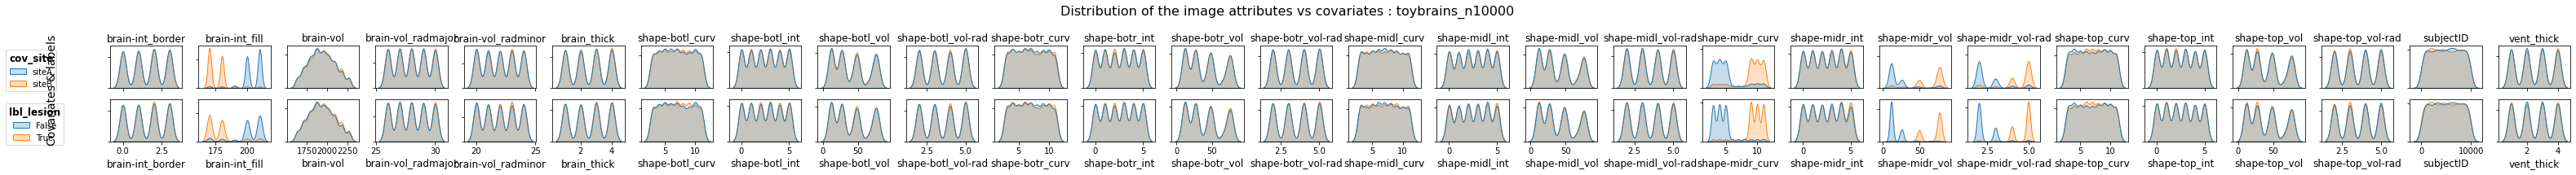

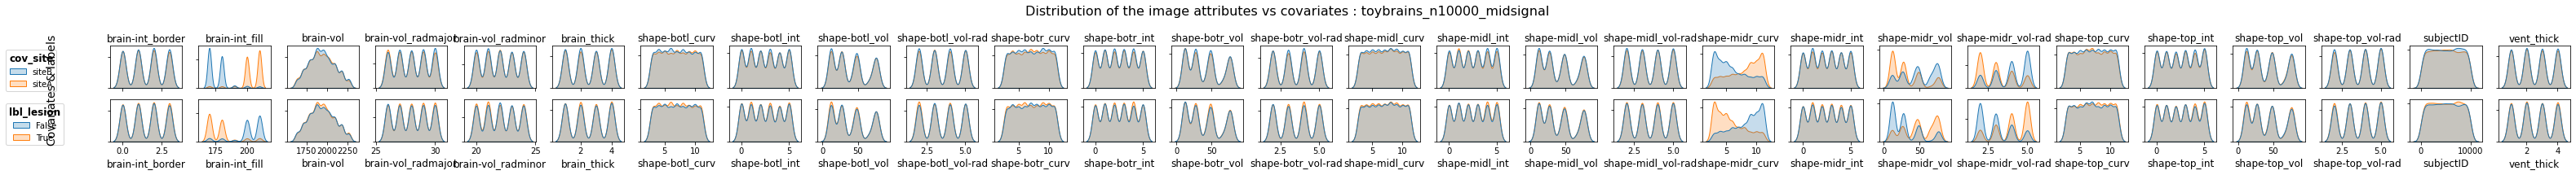

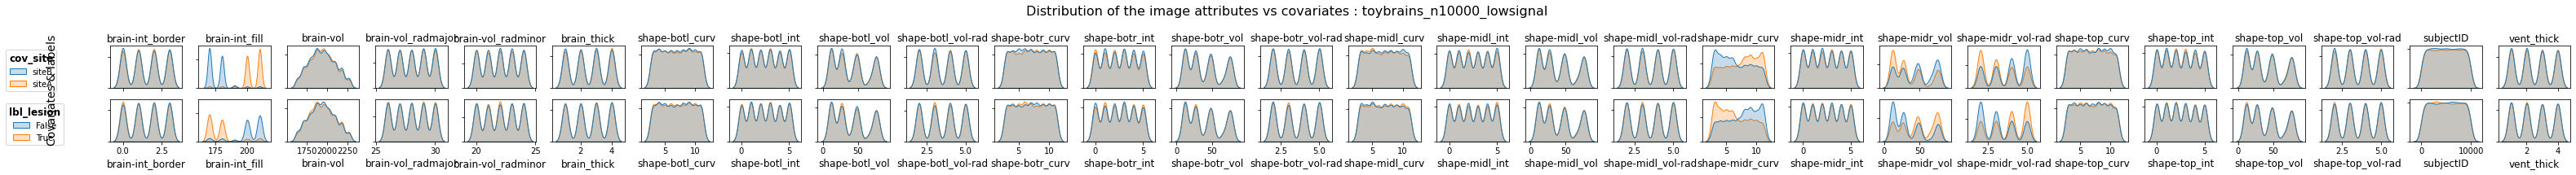

In [7]:
datasets = [("configs.lbl1cov1","../dataset/toybrains_n10000"),
            ("configs.lbl1cov1_midsignal","../dataset/toybrains_n10000_midsignal"),
            ("configs.lbl1cov1_lowsignal","../dataset/toybrains_n10000_lowsignal")]


for _, data_dir in  datasets:
    data_name = data_dir.split('/')[-1]
    df = pd.read_csv(f'{data_dir}/{data_name}.csv')
    cov_cols = df.filter(regex='^(cov_|lbl_)').columns
    attr_cols = df.filter(regex='^(?!(cov_|lbl_)).+').columns
    plot_col_dists(df, 
                   attr_cols=attr_cols, cov_cols=cov_cols, 
                   title=f"Distribution of the image attributes vs covariates : {data_name}")
    plt.show()

## Loading the DataLoader

In [10]:
# choose a target label among the available columns in the table
label = 'lbl_lesion'

In [8]:
# set random seed
seed = 42
torch.manual_seed(seed) 
np.random.seed(seed)
random.seed(seed)
# set the seed for Lightning
L.seed_everything(seed)

Global seed set to 42


42

In [9]:
# dataset
DATA_DIR = '../dataset/toybrains_n10000/'
raw_csv_path = DATA_DIR+'toybrains_n10000.csv'
data_df = pd.read_csv(raw_csv_path).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   subjectID           10000 non-null  int64  
 1   cov_site            10000 non-null  object 
 2   lbl_lesion          10000 non-null  bool   
 3   brain-int_border    10000 non-null  object 
 4   brain-int_fill      10000 non-null  int64  
 5   brain-vol_radmajor  10000 non-null  int64  
 6   brain-vol_radminor  10000 non-null  int64  
 7   brain_thick         10000 non-null  int64  
 8   shape-botl_curv     10000 non-null  int64  
 9   shape-botl_int      10000 non-null  object 
 10  shape-botl_vol-rad  10000 non-null  int64  
 11  shape-botr_curv     10000 non-null  int64  
 12  shape-botr_int      10000 non-null  object 
 13  shape-botr_vol-rad  10000 non-null  int64  
 14  shape-midl_curv     10000 non-null  int64  
 15  shape-midl_int      10000 non-null  object 
 16  shape

In [11]:
# split the dataset for training, validation, and test from raw dataset
df_train, df_val, df_test = split_dataset(raw_csv_path, label, seed)
print(f" Training data split = {len(df_train)} \n Validation data split = {len(df_val)} \n Test data split = {len(df_test)}")

 Training data split = 7809 
 Validation data split = 191 
 Test data split = 2000


### Estimate the baselines
1. [TODO] Accuracy when predicting the most frequent class label:
   ```python
   from collections import Counter
   
   ounter = Counter()
   for images, labels in loader:
       counter.update(labels.tolist())
   print(f"\nLabel distribution: {sorted(counter.items())}")
   
   majority_class = counter.most_common(1)[0]
   print(f"Majority class: {majority_class[0]}")
   
   baseline_acc = majority_class[1] / sum(counter.values())
   print(f"Accuracy when always predicting the majority class: {baseline_acc:.2f} {baseline_acc*100:.2f}%)")
   ```

3. [TODO] best expected accuracy from predicting directly from the image attributes:
4. [TODO] best expected accuracy after deconfounding

In [12]:
# prepare the dataLaoder
train_loader, val_loader, test_loader = get_dataset_loaders(
                    data_split_dfs=[df_train, df_val, df_test],
                    data_dir=DATA_DIR,
                    batch_size=16, shuffle=True, 
                    num_workers=0, transform=[])

### Vizualize the Batch on DataLoader

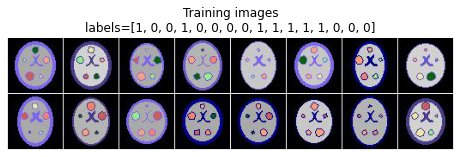

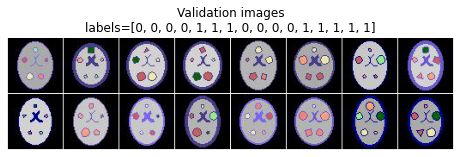

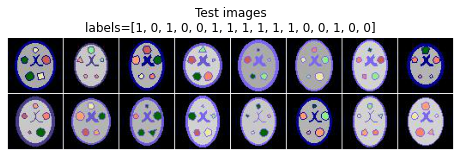

In [13]:
viz_batch(train_loader, title="Training images", debug=True)
viz_batch(val_loader, title="Validation images", debug=True)
viz_batch(test_loader, title="Test images", debug=True)

## Predictive Modeling

### Dataset 1

In [14]:
# logistic regression implmententation

# pytorch_model = LogisticRegression(num_features=12288, num_classes=2, bias=True)

In [15]:
# multi layer perceprton implementation

# pytorch_model = PyTorchMLP(num_features=12288, num_classes=2)

In [16]:
# simple CNN implementation

pytorch_model = SimpleCNN(num_classes=2)

In [17]:
# set denseNet model as default

# pytorch_model = c.DenseNet121(spatial_dims=2, in_channels=3, out_channels=2)

In [18]:
# set lightning model

lightning_model = LightningModel(model=pytorch_model, learning_rate=0.05)

In [21]:
trainer = L.Trainer(
    max_epochs=10,
    accelerator="gpu",
    devices=GPUs,
    logger=CSVLogger(save_dir="logs/", name="new_model"),
    # deterministic=True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [22]:
trainer.fit(
    model=lightning_model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name      | Type           | Params
---------------------------------------------
0 | model     | SimpleCNN      | 1.1 M 
1 | train_acc | BinaryAccuracy | 0     
2 | val_acc   | BinaryAccuracy | 0     
3 | test_acc  | BinaryAccuracy | 0     
---------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.571     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/jihoon/anaconda3/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/home/jihoon/anaconda3/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/jihoon/anaconda3/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the num

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [23]:
train_acc = trainer.test(dataloaders=train_loader)[0]["accuracy"]
val_acc = trainer.test(dataloaders=val_loader)[0]["accuracy"]
test_acc = trainer.test(dataloaders=test_loader)[0]["accuracy"]

print(
    f"Train Acc {train_acc*100:.2f}%"
    f" | Val Acc {val_acc*100:.2f}%"
    f" | Test Acc {test_acc*100:.2f}%"
)

/home/jihoon/anaconda3/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:124: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at logs/new_model/version_25/checkpoints/epoch=9-step=4890.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from checkpoint at logs/new_model/version_25/checkpoints/epoch=9-step=4890.ckpt
/home/jihoon/anaconda3/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/home/jihoon/anaconda3/lib/py

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.9690101146697998     │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at logs/new_model/version_25/checkpoints/epoch=9-step=4890.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from checkpoint at logs/new_model/version_25/checkpoints/epoch=9-step=4890.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.9685863852500916     │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at logs/new_model/version_25/checkpoints/epoch=9-step=4890.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from checkpoint at logs/new_model/version_25/checkpoints/epoch=9-step=4890.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │     0.968500018119812     │
└───────────────────────────┴───────────────────────────┘

Train Acc 96.90% | Val Acc 96.86% | Test Acc 96.85%


In [24]:
# train_result = trainer.test(dataloaders=train_loader)

`Bug on below code: if you use mlti gpu then you may found the several version_X generated on one run.` <br>
Please specify correct metrics.csv which contain all. <br>
(TODO) Refactoring the code on result plot

In [25]:
# metrics = pd.read_csv(f"logs/my_model/version_5/metrics.csv")

# aggreg_metrics = []
# agg_col = "epoch"
# for i, dfg in metrics.groupby(agg_col):
#     agg = dict(dfg.mean())
#     agg[agg_col] = i
#     aggreg_metrics.append(agg)

# df_metrics = pd.DataFrame(aggreg_metrics)
# df_metrics[["train_loss", "val_loss"]].plot(
#     grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
# )
# df_metrics[["train_acc", "val_acc"]].plot(
#     grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
# )

# plt.show()

In [26]:
# PATH = "lightning.pt"
# torch.save(pytorch_model.state_dict(), PATH)

### Dataset 2

In [38]:
# dataset
DATA_DIR = '../dataset/toybrains_n10000_midsignal/'
raw_csv_path = DATA_DIR+'toybrains_n10000_midsignal.csv'
data_df = pd.read_csv(raw_csv_path)
# split the dataset for training, validation, and test from raw dataset
df_train, df_val, df_test = split_dataset(raw_csv_path, label, seed)
print(f" Training data split = {len(df_train)} \n Validation data split = {len(df_val)} \n Test data split = {len(df_test)}")
# prepare the data loader
train_loader, val_loader, test_loader = get_dataset_loaders(
                    data_split_dfs=[df_train, df_val, df_test],
                    data_dir=DATA_DIR,
                    batch_size=16, shuffle=True, transform=[])

 Training data split = 7809 
 Validation data split = 191 
 Test data split = 2000


In [39]:
pytorch_model = SimpleCNN(num_classes=2)
lightning_model = LightningModel(model=pytorch_model, learning_rate=0.05)

In [40]:
trainer = L.Trainer(
    max_epochs=10,
    accelerator="gpu",
    devices=GPUs,
    logger=CSVLogger(save_dir="logs/", name="new_model_midsignal"),
    # deterministic=True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [41]:
trainer.fit(
    model=lightning_model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
)

/ritter/roshan/installations/anaconda3/lib/python3.8/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory logs/new_model_midsignal/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name      | Type           | Params
---------------------------------------------
0 | model     | SimpleCNN      | 1.1 M 
1 | train_acc | BinaryAccuracy | 0     
2 | val_acc   | BinaryAccuracy | 0     
3 | test_acc  | BinaryAccuracy | 0     
---------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.571     Total estimated model params size (MB)
/ritter/roshan/installations/anaconda3/lib/python3.8/site-packages/lightning/fabric/loggers/csv_logs.py:188: UserWarning: Experiment logs directory logs/new_model_midsignal/version_0 exists and is not empty. Previous log files

Sanity Checking: 0it [00:00, ?it/s]

/ritter/roshan/installations/anaconda3/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [42]:
train_acc = trainer.test(dataloaders=train_loader)[0]["accuracy"]
val_acc = trainer.test(dataloaders=val_loader)[0]["accuracy"]
test_acc = trainer.test(dataloaders=test_loader)[0]["accuracy"]

print(
    f"Train Acc {train_acc*100:.2f}%"
    f" | Val Acc {val_acc*100:.2f}%"
    f" | Test Acc {test_acc*100:.2f}%"
)

/ritter/roshan/installations/anaconda3/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at logs/new_model_midsignal/version_0/checkpoints/epoch=9-step=4890-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from the checkpoint at logs/new_model_midsignal/version_0/checkpoints/epoch=9-step=4890-v1.ckpt
/ritter/roshan/installations/anaconda3/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataload

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │     0.86899733543396      │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at logs/new_model_midsignal/version_0/checkpoints/epoch=9-step=4890-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from the checkpoint at logs/new_model_midsignal/version_0/checkpoints/epoch=9-step=4890-v1.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.9109947681427002     │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at logs/new_model_midsignal/version_0/checkpoints/epoch=9-step=4890-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from the checkpoint at logs/new_model_midsignal/version_0/checkpoints/epoch=9-step=4890-v1.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.8725000023841858     │
└───────────────────────────┴───────────────────────────┘

Train Acc 86.90% | Val Acc 91.10% | Test Acc 87.25%


### Dataset 3

In [31]:
# dataset
DATA_DIR = '../dataset/toybrains_n10000_lowsignal/'
raw_csv_path = DATA_DIR+'toybrains_n10000_lowsignal.csv'
data_df = pd.read_csv(raw_csv_path)
# split the dataset for training, validation, and test from raw dataset
df_train, df_val, df_test = split_dataset(raw_csv_path, label, seed)
print(f" Training data split = {len(df_train)} \n Validation data split = {len(df_val)} \n Test data split = {len(df_test)}")
# prepare the data loader
train_loader, val_loader, test_loader = get_dataset_loaders(
                    data_split_dfs=[df_train, df_val, df_test],
                    data_dir=DATA_DIR,
                    batch_size=16, shuffle=True, transform=[])

 Training data split = 7809 
 Validation data split = 191 
 Test data split = 2000


In [32]:
pytorch_model = SimpleCNN(num_classes=2)
lightning_model = LightningModel(model=pytorch_model, learning_rate=0.05)

In [33]:
trainer = L.Trainer(
    max_epochs=10,
    accelerator="gpu",
    devices=GPUs,
    logger=CSVLogger(save_dir="logs/", name="new_model_lowsignal"),
    # deterministic=True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [34]:
trainer.fit(
    model=lightning_model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
)

Missing logger folder: logs/new_model_lowsignal
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name      | Type           | Params
---------------------------------------------
0 | model     | SimpleCNN      | 1.1 M 
1 | train_acc | BinaryAccuracy | 0     
2 | val_acc   | BinaryAccuracy | 0     
3 | test_acc  | BinaryAccuracy | 0     
---------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.571     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/ritter/roshan/installations/anaconda3/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [36]:
train_acc = trainer.test(dataloaders=train_loader)[0]["accuracy"]
val_acc = trainer.test(dataloaders=val_loader)[0]["accuracy"]
test_acc = trainer.test(dataloaders=test_loader)[0]["accuracy"]

print(
    f"Train Acc {train_acc*100:.2f}%"
    f" | Val Acc {val_acc*100:.2f}%"
    f" | Test Acc {test_acc*100:.2f}%"
)

Restoring states from the checkpoint path at logs/new_model_lowsignal/version_0/checkpoints/epoch=9-step=4890.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from the checkpoint at logs/new_model_lowsignal/version_0/checkpoints/epoch=9-step=4890.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.8805224895477295     │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at logs/new_model_lowsignal/version_0/checkpoints/epoch=9-step=4890.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from the checkpoint at logs/new_model_lowsignal/version_0/checkpoints/epoch=9-step=4890.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.8638743162155151     │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at logs/new_model_lowsignal/version_0/checkpoints/epoch=9-step=4890.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from the checkpoint at logs/new_model_lowsignal/version_0/checkpoints/epoch=9-step=4890.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.8700000047683716     │
└───────────────────────────┴───────────────────────────┘

Train Acc 88.05% | Val Acc 86.39% | Test Acc 87.00%
